In [1]:
import pysensors as ps
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle

### Load the Olivetti Dataset

In [2]:
faces = datasets.fetch_olivetti_faces(shuffle=True, random_state=99)
X = faces.data

n_samples, n_features = X.shape
print(n_samples, n_features)

400 4096


In [3]:
# Global centering
X = X - X.mean(axis=0)

# Local centering
X -= X.mean(axis=1).reshape(n_samples, -1)

In [4]:
# From https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

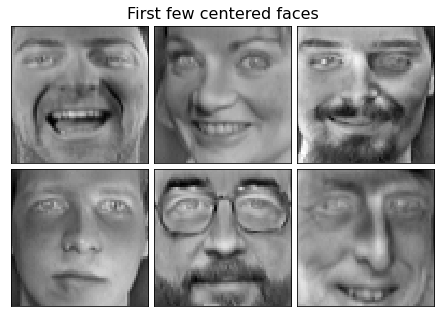

In [5]:
plot_gallery("First few centered faces", X[:n_components])

In [6]:
X_train, X_test = X[:300], X[300:]

### Unconstrained sensor placaement:


In [7]:
n_sensors = min(n_features,300)
n_modes = n_sensors
basis_unconst = ps.basis.SVD(n_basis_modes = n_modes)
optimizer_unconst_full = ps.optimizers.QR()
model_unconst_full = ps.SSPOR(basis = basis_unconst, optimizer = optimizer_unconst_full, n_sensors = n_sensors)
model_unconst_full.fit(X_train)
all_sensors_unconst_full = model_unconst_full.get_all_sensors()

/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [8]:
np.shape(X_train)

(300, 4096)

In [9]:
all_sensors_unconst_full[:15]

array([4032, 4035, 1101, 4038, 4034, 4095, 4092, 1024, 1036, 4090, 3844,
       1074, 4087, 2560, 1071], dtype=int32)

In [10]:
xFullUnc = np.mod(all_sensors_unconst_full,np.sqrt(n_features))
yFullUnc = np.floor(all_sensors_unconst_full/np.sqrt(n_features))

In [11]:
#Sensor ID corresponds to the column number chosen
columns_full = ['Sensor ID','SensorX','sensorY'] 
unconstrainedSensors_df_full = pd.DataFrame(data = np.vstack([all_sensors_unconst_full,xFullUnc,yFullUnc]).T,columns=columns_full,dtype=int)
unconstrainedSensors_df_full.head(15)

,Sensor ID,SensorX,sensorY
0,4032,0,63
1,4035,3,63
2,1101,13,17
3,4038,6,63
4,4034,2,63
5,4095,63,63
6,4092,60,63
7,1024,0,16
8,1036,12,16
9,4090,58,63


In [12]:
n_sensors = 10
n_modes = 10
buffer = 5
basis_unconst = ps.basis.SVD(n_basis_modes = n_modes)
optimizer_unconst = ps.optimizers.QR()
model_unconst = ps.SSPOR(basis = basis_unconst, optimizer = optimizer_unconst, n_sensors = n_sensors)
model_unconst.fit(X_train)
all_sensors_unconst = model_unconst.get_all_sensors()
sensors_unconst = model_unconst.get_selected_sensors()

/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [13]:
xTopUnc = np.mod(sensors_unconst,np.sqrt(n_features))  ### Need to delete this and show how this can be done with functions only.
yTopUnc = np.floor(sensors_unconst/np.sqrt(n_features))
xAllUnc = np.mod(all_sensors_unconst,np.sqrt(n_features))
yAllUnc = np.floor(all_sensors_unconst/np.sqrt(n_features))

In [14]:
#Sensor ID corresponds to the column number chosen
columns = ['Sensor ID','SensorX','sensorY'] 
unconstrainedSensors_df = pd.DataFrame(data = np.vstack([sensors_unconst,xTopUnc,yTopUnc]).T,columns=columns,dtype=int)
unconstrainedSensors_df.head(n_sensors)

,Sensor ID,SensorX,sensorY
0,4032,0,63
1,594,18,9
2,384,0,6
3,878,46,13
4,446,62,6
5,2772,20,43
6,4041,9,63
7,3936,32,61
8,340,20,5
9,2273,33,35


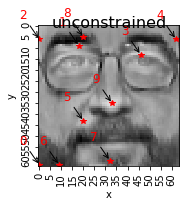

In [15]:
# Plot the constrained region and the unconstrained sensors where 1 is the first sensor chosen.
image = X_train[4,:].reshape(1,-1)

plot_gallery('unconstrained', image, n_col=1, n_row=1, cmap=plt.cm.gray)
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

### Functional constaints:

Suppose the user wants to constrain a circular aea centered at x = 20, y = 30 with a radius (r = 5)

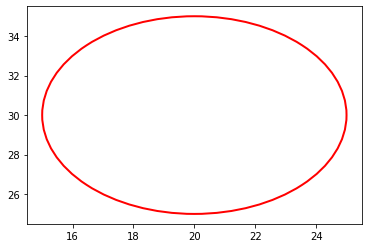

In [16]:
circle = ps.utils._constraints.Circle(center_x = 20, center_y = 30, radius = 5, loc = 'in', data = X_train) #Plotting the constrained circle 
circle.draw_constraint() ###Plotting just the constraint

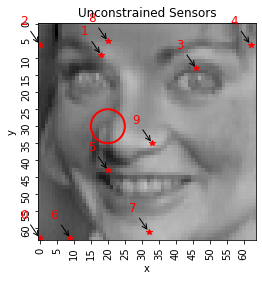

In [17]:
circle.plot_constraint_on_data(plot_type='image') ##Plotting the constraint on the data
plt.plot(xTopUnc, yTopUnc,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Unconstrained Sensors')
plt.xticks(np.arange(0,64,5),rotation=90)
plt.yticks(np.arange(0,64,5),rotation=90)
for ind,i in enumerate(range(len(xTopUnc))):
    plt.annotate(f"{str(ind)}",(xTopUnc[i],yTopUnc[i]),xycoords='data',
                 xytext=(-20,20), textcoords='offset points',color="r",fontsize=12,
                 arrowprops=dict(arrowstyle="->", color='black'))

### Plotting grid of possible sensor locations

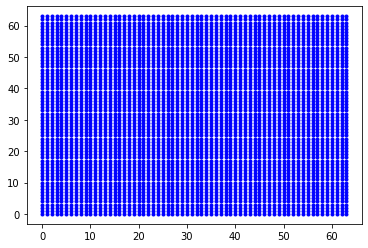

In [18]:
circle.plot_grid(all_sensors=all_sensors_unconst)

### Obtaining constrained indices :

In [19]:
const_idx, rank = circle.get_constraint_indices(all_sensors = all_sensors_unconst,info= X_train)  #get_indices

In [20]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 4
# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_circle = ps.optimizers.GQR()
opt_exact_kws={'idx_constrained':const_idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_exact = ps.basis.SVD(n_basis_modes=n_sensors)

In [21]:
# Initialize and fit the model
model_exact = ps.SSPOR(basis = basis_exact, optimizer = optimizer_circle, n_sensors = n_sensors)
model_exact.fit(X_train,**opt_exact_kws)

# sensor locations based on columns of the data matrix
top_sensors_exact = model_exact.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConst = np.mod(top_sensors_exact,np.sqrt(n_features))
yTopConst = np.floor(top_sensors_exact/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032  594  384  878  446 2772 1945 2132 2199 1810]


/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [22]:
data_sens_circle = circle.sensors_dataframe(sensors = top_sensors_exact)
data_sens_circle

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,1945.0,25.0,30.0
7,2132.0,20.0,33.0
8,2199.0,23.0,34.0
9,1810.0,18.0,28.0


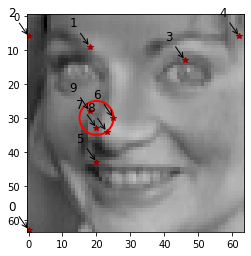

In [23]:
circle.plot_constraint_on_data(plot_type='image')
circle.plot_selected_sensors(sensors = top_sensors_exact)
circle.annotate_sensors(sensors = top_sensors_exact, color = 'black')

### We want to constrain the region beyond x = 10 and x = 20 and y = 0 and y = 64

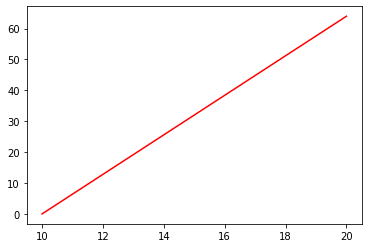

In [24]:
line1 = ps.utils._constraints.Line(x1 = 10, x2 = 20, y1 = 0, y2 = 64, data = X_train) #Plotting the constrained line  ##expect a tuple of (x,y)
line1.draw_constraint() ## plotting just the constraint

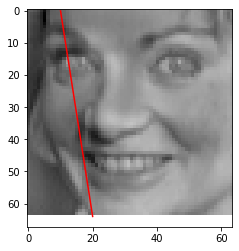

In [25]:
line1.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data

In [26]:
const_idx1, rank1 = line1.get_constraint_indices(all_sensors=all_sensors_unconst, info = X_train)

In [27]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 5

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_line = ps.optimizers.GQR()
opt_line_kws={'idx_constrained':const_idx1,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_line = ps.basis.SVD(n_basis_modes=n_sensors)

In [28]:
# Initialize and fit the model
model_line = ps.SSPOR(basis = basis_line, optimizer = optimizer_line, n_sensors = n_sensors)
model_line.fit(X_train,**opt_line_kws)

# sensor locations based on columns of the data matrix
top_sensors_line = model_line.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstLine = np.mod(top_sensors_line,np.sqrt(n_features))
yTopConstLine = np.floor(top_sensors_line/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032  594  384  878  446 2772 1945 2132 2199 1810]


/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [29]:
data_sens_line = line1.sensors_dataframe(sensors = top_sensors_line)
data_sens_line

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,393.0,9.0,6.0
9,3922.0,18.0,61.0


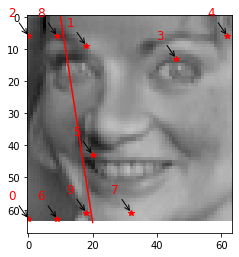

In [30]:
line1.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
line1.plot_selected_sensors(sensors = top_sensors_line)
line1.annotate_sensors(sensors = top_sensors_line)

### Testing Ellipse: 

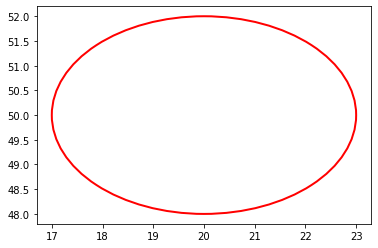

In [31]:
ellipse = ps.utils._constraints.Ellipse(center_x = 20, center_y = 50, half_major_axis = 6, half_minor_axis = 4, loc = 'out',data = X_train) #Plotting the constrained circle 
ellipse.draw_constraint() ###Plotting just the constraint

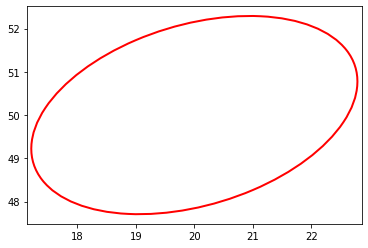

In [32]:
ellipse = ps.utils._constraints.Ellipse(center_x = 20, center_y = 50, half_major_axis = 6, half_minor_axis = 4, angle=120.0,loc = 'in',data = X_train) #Plotting the constrained circle 
ellipse.draw_constraint() ###Plotting just the constraint

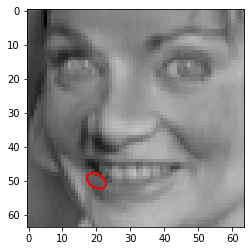

In [33]:
ellipse.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data

In [34]:
const_idx_ellipse, rank_ellipse = ellipse.get_constraint_indices(all_sensors=all_sensors_unconst, info = X_train)

In [35]:
# Define the number of constrained sensors allowed (s)
n_const_sen_ellipse = 1

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_ellipse = ps.optimizers.GQR()
opt_ellipse_kws={'idx_constrained':const_idx_ellipse,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_ellipse,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_ellipse = ps.basis.SVD(n_basis_modes=n_sensors)

In [36]:
# Initialize and fit the model
model_ellipse = ps.SSPOR(basis = basis_ellipse, optimizer = optimizer_ellipse, n_sensors = n_sensors)
model_ellipse.fit(X_train,**opt_ellipse_kws)

# sensor locations based on columns of the data matrix
top_sensors_ellipse = model_ellipse.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstEllipse = np.mod(top_sensors_ellipse,np.sqrt(n_features))
yTopConstEllipse = np.floor(top_sensors_ellipse/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_ellipse))

The list of sensors selected is: [4032  594  384  878  446 2772 4041 3936  340 3347]


/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [37]:
data_sens_ellipse = ellipse.sensors_dataframe(sensors = top_sensors_ellipse)
data_sens_ellipse

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,340.0,20.0,5.0
9,3347.0,19.0,52.0


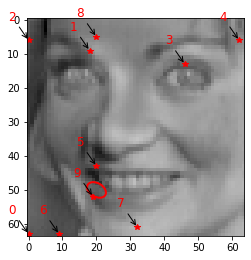

In [38]:
ellipse.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
ellipse.plot_selected_sensors(sensors = top_sensors_ellipse)
ellipse.annotate_sensors(sensors = top_sensors_ellipse)

## Polygonal Constraints

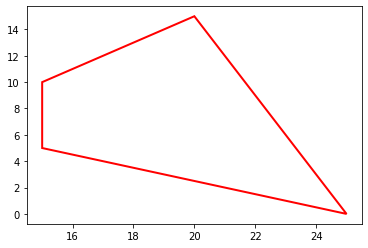

In [39]:
polygon = ps.utils._constraints.Polygon([(20,15),(25,0),(15,5),(15,10)],data = X_train) #Plotting the constrained circle 
polygon.draw_constraint() ###Plotting just the constraint

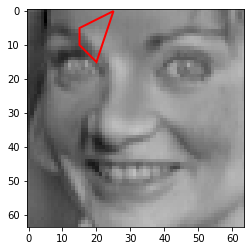

In [40]:
polygon.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!

In [41]:
const_idx_polygon, rank_polygon = polygon.get_constraint_indices(all_sensors=all_sensors_unconst_full, info = X_train)
print(const_idx_polygon)

[787, 725, 592, 464, 721, 788, 658, 341, 336, 596, 531, 404, 469, 851, 528, 279, 276, 339, 340, 533, 723, 916, 657, 467, 277, 213, 724, 212, 466, 152, 150, 594, 852, 470, 786, 789, 597, 405, 88, 403, 401, 534, 593, 275, 406, 342, 598, 338, 468, 400, 659, 343, 216, 407, 337, 465, 402, 278, 530, 151, 661, 660, 214, 215, 274, 532, 656, 595, 529, 722]


In [42]:
# Define the number of constrained sensors allowed (s)
n_const_sen_polygon = 0

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_polygon = ps.optimizers.GQR()
opt_polygon_kws={'idx_constrained':const_idx_polygon,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_polygon,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"max_n"}
basis_polygon = ps.basis.SVD(n_basis_modes=n_sensors)

In [43]:
# Initialize and fit the model
model_polygon = ps.SSPOR(basis = basis_polygon, optimizer = optimizer_polygon, n_sensors = n_sensors)
model_polygon.fit(X_train,**opt_polygon_kws)

# sensor locations based on columns of the data matrix
top_sensors_polygon = model_polygon.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstPolygon = np.mod(top_sensors_polygon,np.sqrt(n_features))
yTopConstPolygon = np.floor(top_sensors_polygon/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_polygon))

The list of sensors selected is: [4032  591  384  878  446 2772 4041 3936  429 2479]


/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [44]:
data_sens_polygon = polygon.sensors_dataframe(sensors = top_sensors_polygon)
data_sens_polygon

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,591.0,15.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,4041.0,9.0,63.0
7,3936.0,32.0,61.0
8,429.0,45.0,6.0
9,2479.0,47.0,38.0


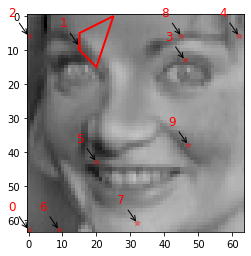

In [45]:
polygon.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
polygon.annotate_sensors(sensors = top_sensors_polygon)

## Non convex polygon

In [46]:
polygon2 = ps.utils._constraints.Polygon([(20,15),(25,0),(15,5),(20,7)],data = X_train) #Plotting the constrained circle 

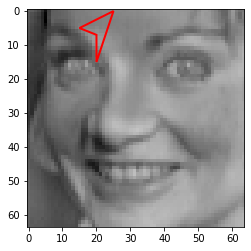

In [47]:
polygon2.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!

In [49]:
const_idx_polygon2, rank_polygon2 = polygon2.get_constraint_indices(all_sensors=all_sensors_unconst, info = X_train)
print(const_idx_polygon2)


[340, 342, 214, 337, 213, 88, 661, 274, 404, 277, 276, 598, 151, 725, 279, 343, 405, 216, 212, 336, 597, 278, 152, 338, 534, 150, 789, 533, 339, 406, 402, 403, 215, 407, 469, 275, 470, 341]


In [50]:
print(rank_polygon2)

[8, 74, 197, 223, 357, 565, 596, 637, 644, 681, 727, 768, 898, 1166, 1493, 1595, 1624, 1680, 1885, 1957, 2136, 2185, 2215, 2275, 2315, 2357, 2575, 2607, 2911, 2969, 3064, 3231, 3267, 3370, 3428, 3446, 3812, 3921]


In [51]:
# Define the number of constrained sensors allowed (s)
n_const_sen_polygon = 4

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_polygon2 = ps.optimizers.GQR()
opt_polygon_kws2={'idx_constrained':const_idx_polygon2,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sen_polygon,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_polygon = ps.basis.SVD(n_basis_modes=n_sensors)

In [52]:
# Initialize and fit the model
model_polygon2 = ps.SSPOR(basis = basis_polygon, optimizer = optimizer_polygon2, n_sensors = n_sensors)
model_polygon2.fit(X_train,**opt_polygon_kws2)

# sensor locations based on columns of the data matrix
top_sensors_polygon2 = model_polygon2.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstPolygon2 = np.mod(top_sensors_polygon2,np.sqrt(n_features))
yTopConstPolygon2 = np.floor(top_sensors_polygon2/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_polygon2))

The list of sensors selected is: [4032  594  384  878  446 2772  340  725   88  469]


/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [53]:
data_sens_polygon2 = polygon2.sensors_dataframe(sensors = top_sensors_polygon2)
data_sens_polygon2

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,340.0,20.0,5.0
7,725.0,21.0,11.0
8,88.0,24.0,1.0
9,469.0,21.0,7.0


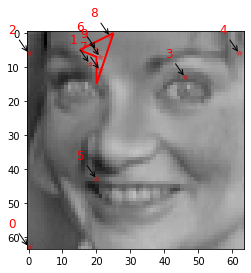

In [55]:
polygon2.plot_constraint_on_data(plot_type='image') ## Plotting the constraint on the data!
polygon2.annotate_sensors(sensors = top_sensors_polygon2)

## User defined constraints

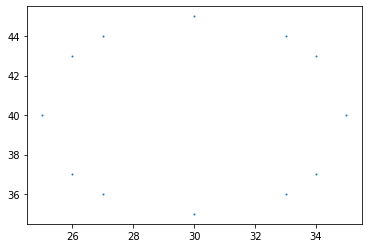

In [56]:
user_const = 'userExplicitConstraint1.py'
user_const_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors_unconst,data = X_train, file = user_const)
idx, rank = user_const_instance.constraint()
user_const_instance.draw_constraint() ## plot the user defined constraint just by itself

In [57]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 4

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_user = ps.optimizers.GQR()
opt_user_kws={'idx_constrained':idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_user = ps.basis.SVD(n_basis_modes=n_sensors)

In [58]:
# Initialize and fit the model
model_user = ps.SSPOR(basis = basis_user, optimizer = optimizer_user, n_sensors = n_sensors)
model_user.fit(X_train,**opt_user_kws)

# sensor locations based on columns of the data matrix
top_sensors_user = model_user.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstUser = np.mod(top_sensors_user,np.sqrt(n_features))
yTopConstUser = np.floor(top_sensors_user/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [4032  594  384  878  446 2772 1945 2132 2199 1810]


/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [59]:
data_sens_user = user_const_instance.sensors_dataframe(sensors = top_sensors_user)
data_sens_user

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,446.0,62.0,6.0
5,2772.0,20.0,43.0
6,2587.0,27.0,40.0
7,2466.0,34.0,38.0
8,2395.0,27.0,37.0
9,2658.0,34.0,41.0


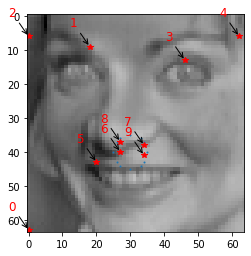

In [60]:
## Verifying whther user-defined constraints work

user_const_instance.plot_constraint_on_data(plot_type='image') 
user_const_instance.plot_selected_sensors(sensors = top_sensors_user)
user_const_instance.annotate_sensors(sensors = top_sensors_user)

### Now let us consider an example where the user inputs the equation that they are considering as a constraint in a string of the form (x-30)^2 + (y-40)^2 < 25

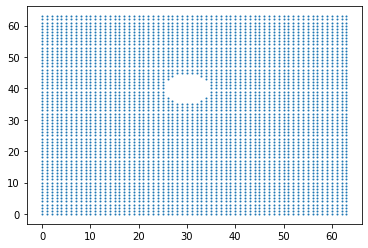

In [61]:
user_const_stg = '(x-30)**2 + (y-40)**2 < 5**2'
user_const_stg_instance = ps.utils._constraints.UserDefinedConstraints(all_sensors_unconst,data = X_train, equation = user_const_stg)
idx_stg, rank_stg = user_const_stg_instance.constraint()
user_const_stg_instance.draw_constraint() ## plot the user defined constraint just by itself

In [62]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 4

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_user_stg = ps.optimizers.GQR()
opt_user_kws_stg={'idx_constrained':idx_stg,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors_unconst,
         'constraint_option':"exact_n"}
basis_user_stg = ps.basis.SVD(n_basis_modes=n_sensors)

In [63]:
# Initialize and fit the model
model_user_stg = ps.SSPOR(basis = basis_user_stg, optimizer = optimizer_user_stg, n_sensors = n_sensors)
model_user_stg.fit(X_train,**opt_user_kws_stg)

# sensor locations based on columns of the data matrix
top_sensors_user_stg = model_user_stg.get_selected_sensors()

# sensor locations based on pixels of the image
xTopConstUser_stg = np.mod(top_sensors_user_stg,np.sqrt(n_features))
yTopConstUser_stg = np.floor(top_sensors_user_stg/np.sqrt(n_features))

print('The list of sensors selected is: {}'.format(top_sensors_user_stg))

The list of sensors selected is: [4032  594  384  878 2589 2336 2714 2332 2846 2658]


/Users/niharikakarnik/projects/pysensors/pysensors/reconstruction/_sspor.py:517: UserWarning: Number of sensors exceeds number of samples, which may cause CCQR to select sensors in constrained regions.
  warnings.warn(


In [64]:
data_sens_user_stg = user_const_stg_instance.sensors_dataframe(sensors = top_sensors_user_stg)
data_sens_user_stg

,Sensor ID,SensorX,sensorY
0,4032.0,0.0,63.0
1,594.0,18.0,9.0
2,384.0,0.0,6.0
3,878.0,46.0,13.0
4,2589.0,29.0,40.0
5,2336.0,32.0,36.0
6,2714.0,26.0,42.0
7,2332.0,28.0,36.0
8,2846.0,30.0,44.0
9,2658.0,34.0,41.0


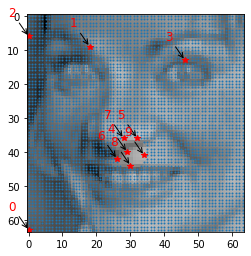

In [65]:
## Verifying whther user-defined constraints work

user_const_stg_instance.plot_constraint_on_data(plot_type='image') 
user_const_stg_instance.plot_selected_sensors(sensors = top_sensors_user_stg)
user_const_stg_instance.annotate_sensors(sensors = top_sensors_user_stg)